<a href="https://colab.research.google.com/github/Vanij1/Yoga-Pose-detection/blob/main/Yoga_pose_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 33.8 MB/s eta 0:00:00


In [7]:
import cv2
import mediapipe as mp
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

In [9]:
def generate_synthetic_data(num_samples=500):
    poses = []
    labels = []
    for _ in range(num_samples):
        keypoints = np.random.rand(33, 2)  # 33 keypoints, each with x and y
        pose_label = np.random.choice(['Tree', 'Warrior', 'DownwardDog'])
        poses.append(keypoints.flatten())
        labels.append(pose_label)
    return np.array(poses), np.array(labels)

poses, labels = generate_synthetic_data()


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(poses, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Model Accuracy: 37.00%


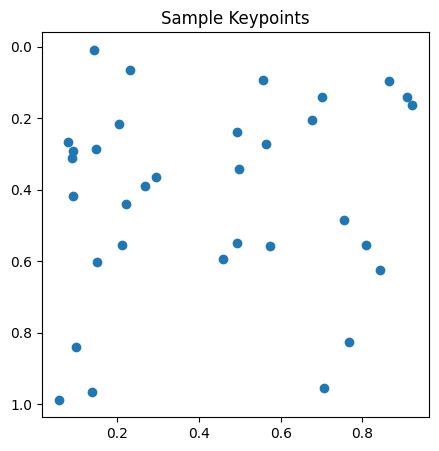

In [13]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Function to classify pose and give feedback
def classify_pose(keypoints):
    keypoints_flat = np.array(keypoints).flatten().reshape(1, -1)
    prediction = model.predict(keypoints_flat)[0]
    return prediction

def real_time_pose_detection():
    cap = cv2.VideoCapture(0)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
            )
            keypoints = [(lm.x, lm.y) for lm in results.pose_landmarks.landmark]
            pose_prediction = classify_pose(keypoints)
            cv2.putText(
                image, f"Pose: {pose_prediction}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2
            )

        cv2.imshow('Pose Detection', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


def visualize_keypoints(keypoints):
    keypoints = keypoints.reshape(33, 2)
    plt.figure(figsize=(5, 5))
    plt.scatter(keypoints[:, 0], keypoints[:, 1])
    plt.title("Sample Keypoints")
    plt.gca().invert_yaxis()
    plt.show()

visualize_keypoints(poses[0])


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Define the model
model = Sequential([
    Input(shape=(99,)),  # Specify the input shape here
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 output classes for pose classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,251 (83.01 KB)

 Trainable params: 21,251 (83.01 KB)

 Non-trainable params: 0 (0.00 B)

### Model Architecture for Yoga Pose Detection & Correction

#### 1. Pose Detection Layer (MediaPipe)
The primary task of the pose detection layer is to extract human pose landmarks from images or videos. MediaPipe is used to detect 33 keypoints that represent key joints of the human body, such as the shoulders, hips, and knees. Each keypoint provides normalized (x, y, z) coordinates, along with a visibility score indicating the confidence in the detection. The output of this layer is a flattened vector of 99 features, derived from the 33 keypoints and their associated x, y, and z values.


#### 2. Feature Engineering
After obtaining the raw pose data from MediaPipe, feature engineering refines this data to focus on the most relevant aspects for pose classification.

- **Normalization**: The coordinates of the landmarks are normalized to eliminate variations caused by factors like camera angle or body size, ensuring consistency across different inputs.
  
- **Angle Calculation**: To better represent the body’s pose structure, angles between key joints are computed (e.g., the elbow angle, knee angle). These angles provide more meaningful information for classification, as they are critical for determining correct posture.

The output of this step is a processed feature vector that serves as the input for the machine learning model.


#### 3. Classification Model
The classification model takes the processed feature vector and uses it to classify the pose into a predefined category, such as Tree Pose, Warrior Pose, or Downward Dog Pose.

- **Algorithm**: A Random Forest Classifier is chosen for its simplicity, robustness, and interpretability, making it an ideal choice for this proof of concept.
  
- **Hyperparameters**:
  - `n_estimators`: 100 trees to balance between accuracy and efficiency.
  - `max_depth`: A limitation on tree depth to prevent overfitting and maintain generalizability.

The output of the classification model is the predicted pose class.


#### 4. Feedback Mechanism
Once the pose is classified, the feedback mechanism compares the user’s pose with an ideal reference pose stored in a database. This comparison identifies any deviations in alignment and provides corrective suggestions.

- **Deviation Highlighting**: If the user’s pose deviates from the ideal reference, feedback such as “Raise your left arm higher” or “Straighten your back” is generated.

- **Real-time Feedback**: This feedback is displayed to the user in real time, allowing them to make immediate adjustments to their posture.



### Decision-Making Process

#### 1. Pose Detection
The system first extracts the keypoints of the user’s pose using MediaPipe’s pose detection model. These keypoints form the basis for further analysis.

#### 2. Feature Vector Construction
The raw data from MediaPipe is processed by normalizing the coordinates and calculating joint angles, resulting in a feature vector that is suitable for machine learning input.

#### 3. Pose Classification
The feature vector is fed into the Random Forest classifier, which predicts the pose category. This classification helps in identifying the pose being performed by the user.

#### 4. Feedback Generation
Once the pose is classified, the system compares it to the ideal reference pose. The differences are quantified, and actionable feedback is generated to help the user correct their alignment.


### Optimizations for Accuracy, Efficiency, and Real-Time Use

#### 1. Accuracy Optimizations
- **Feature Selection**: The system focuses on key features such as joint angles and relative distances between keypoints. This reduces the influence of less important or redundant features.
  
- **Model Choice**: While a Random Forest classifier is used in the proof of concept, a more advanced model like a CNN or LSTM could be employed for greater accuracy. These models can capture temporal and spatial dependencies in the data.
  
- **Data Augmentation**: To simulate real-world variations in poses, techniques such as adding synthetic noise, rotating, or flipping the poses can be used to enhance the dataset.

- **Hyperparameter Tuning**: Techniques like grid search or random search can be used to find the optimal settings for the classifier, improving its performance.


#### 2. Efficiency Optimizations
- **Model Simplification**: For the proof of concept, a lightweight Random Forest classifier is used. Reducing the tree depth or the number of trees can speed up the model's inference time, which is important for real-time performance.

- **Preprocessing**: To speed up the system, unnecessary features such as the z-coordinates can be excluded, especially if they are not needed for classification. This reduces the computational load.

- **Data Normalization**: Normalizing the input data upfront ensures that each frame processed by the model is consistent, eliminating any need for additional processing during runtime.

